# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7730.52294921875
iteration 0 loss 2902.8974609375


iteration 500 loss 104.86195373535156


iteration 1000 loss 99.2545166015625


iteration 1500 loss 96.53080749511719


iteration 2000 loss 93.65470123291016


iteration 2500 loss 89.9656982421875


iteration 3000 loss 85.15156555175781


iteration 3500 loss 78.46558380126953


iteration 4000 loss 67.96333312988281


iteration 4500 loss 47.692874908447266


iteration 5000 loss 18.144712448120117


iteration 5500 loss 5.710790634155273


iteration 6000 loss 3.1468844413757324


iteration 6500 loss 2.456929922103882


iteration 7000 loss 2.0603408813476562


iteration 7500 loss 1.7233145236968994


iteration 8000 loss 1.4367789030075073


iteration 8500 loss 1.1910831928253174


iteration 9000 loss 1.0745103359222412


iteration 9500 loss 0.9809895753860474


iteration 10000 loss 0.8845997452735901


iteration 10500 loss 0.7853146195411682


iteration 11000 loss 0.6844834685325623


iteration 11500 loss 0.6408376097679138


iteration 12000 loss 0.6151520013809204


iteration 12500 loss 0.5859772562980652


iteration 13000 loss 0.5526255369186401


iteration 13500 loss 0.5151812434196472


iteration 14000 loss 0.4741792380809784


iteration 14500 loss 0.4305954575538635


iteration 15000 loss 0.41226211190223694


iteration 15500 loss 0.40118610858917236


iteration 16000 loss 0.3883913457393646


iteration 16500 loss 0.37326958775520325


iteration 17000 loss 0.3555203676223755


iteration 17500 loss 0.3350170850753784


iteration 18000 loss 0.31177395582199097


iteration 18500 loss 0.3037562966346741


iteration 19000 loss 0.29626452922821045


iteration 19500 loss 0.2874298095703125


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.2768608033657074


iteration 20500 loss 0.2755591869354248


iteration 21000 loss 0.2739068269729614


iteration 21500 loss 0.27181535959243774


iteration 22000 loss 0.2691802978515625


iteration 22500 loss 0.26587939262390137


iteration 23000 loss 0.26177340745925903


iteration 23500 loss 0.2567044198513031


iteration 24000 loss 0.2505146861076355


iteration 24500 loss 0.24306315183639526


iteration 25000 loss 0.23426301777362823


iteration 25500 loss 0.22406871616840363


iteration 26000 loss 0.21638870239257812


iteration 26500 loss 0.21237695217132568


iteration 27000 loss 0.20751452445983887


iteration 27500 loss 0.2016819417476654


iteration 28000 loss 0.19478991627693176


iteration 28500 loss 0.18687090277671814


iteration 29000 loss 0.18491126596927643


iteration 29500 loss 0.182664155960083


iteration 30000 loss 0.17988893389701843


iteration 30500 loss 0.17648713290691376


iteration 31000 loss 0.17236390709877014


iteration 31500 loss 0.1674290895462036


iteration 32000 loss 0.1616099774837494


iteration 32500 loss 0.15922416746616364


iteration 33000 loss 0.15732739865779877


iteration 33500 loss 0.1549847275018692


iteration 34000 loss 0.15210959315299988


iteration 34500 loss 0.14862041175365448


iteration 35000 loss 0.14443883299827576


iteration 35500 loss 0.14141875505447388


iteration 36000 loss 0.14035062491893768


iteration 36500 loss 0.13901762664318085


iteration 37000 loss 0.13735978305339813


iteration 37500 loss 0.13531309366226196


iteration 38000 loss 0.13280794024467468


iteration 38500 loss 0.12977129220962524


iteration 39000 loss 0.12632091343402863


iteration 39500 loss 0.1251004934310913


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.1237255111336708


iteration 40500 loss 0.1235538199543953


iteration 41000 loss 0.12333550304174423


iteration 41500 loss 0.12306012213230133


iteration 42000 loss 0.12271423637866974


iteration 42500 loss 0.12228197604417801


iteration 43000 loss 0.12174537032842636


iteration 43500 loss 0.1210843175649643


iteration 44000 loss 0.12027847021818161


iteration 44500 loss 0.11931005865335464


iteration 45000 loss 0.11816394329071045


iteration 45500 loss 0.11683104187250137


iteration 46000 loss 0.11531496047973633


iteration 46500 loss 0.1136261522769928


iteration 47000 loss 0.11192190647125244


iteration 47500 loss 0.11030180007219315


iteration 48000 loss 0.1087566390633583


iteration 48500 loss 0.10721750557422638


iteration 49000 loss 0.10578200221061707


iteration 49500 loss 0.10431324690580368


iteration 50000 loss 0.10302767157554626


iteration 50500 loss 0.10168293118476868


iteration 51000 loss 0.10039781779050827


iteration 51500 loss 0.0991317480802536


iteration 52000 loss 0.09790143370628357


iteration 52500 loss 0.09668779373168945


iteration 53000 loss 0.09556128084659576


iteration 53500 loss 0.09443710744380951


iteration 54000 loss 0.09332713484764099


iteration 54500 loss 0.09230680763721466


iteration 55000 loss 0.09118525683879852


iteration 55500 loss 0.09027687460184097


iteration 56000 loss 0.08924345672130585


iteration 56500 loss 0.08829500526189804


iteration 57000 loss 0.08735571056604385


iteration 57500 loss 0.08638496696949005


iteration 58000 loss 0.08554184436798096


iteration 58500 loss 0.08458343148231506


iteration 59000 loss 0.08380786329507828


iteration 59500 loss 0.08298011869192123


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.08209138363599777


iteration 60500 loss 0.08202050626277924


iteration 61000 loss 0.08193756639957428


iteration 61500 loss 0.08184201270341873


iteration 62000 loss 0.08173348009586334


iteration 62500 loss 0.0816119983792305


iteration 63000 loss 0.08147823810577393


iteration 63500 loss 0.08133336901664734


iteration 64000 loss 0.08117903023958206


iteration 64500 loss 0.0810173749923706


iteration 65000 loss 0.08085015416145325


iteration 65500 loss 0.08067896962165833


iteration 66000 loss 0.0805051326751709


iteration 66500 loss 0.08032975345849991


iteration 67000 loss 0.08015363663434982


iteration 67500 loss 0.07997719198465347


iteration 68000 loss 0.07980099320411682


iteration 68500 loss 0.07962522655725479


iteration 69000 loss 0.07945024967193604


iteration 69500 loss 0.07927647978067398


iteration 70000 loss 0.07910382002592087


iteration 70500 loss 0.07893217355012894


iteration 71000 loss 0.07876162230968475


iteration 71500 loss 0.07859206944704056


iteration 72000 loss 0.07842356711626053


iteration 72500 loss 0.07825596630573273


iteration 73000 loss 0.07808931916952133


iteration 73500 loss 0.07792361825704575


iteration 74000 loss 0.07775888592004776


iteration 74500 loss 0.07759498804807663


iteration 75000 loss 0.07743187993764877


iteration 75500 loss 0.07726950198411942


iteration 76000 loss 0.07710789144039154


iteration 76500 loss 0.076946921646595


iteration 77000 loss 0.07678662985563278


iteration 77500 loss 0.07662706077098846


iteration 78000 loss 0.0764681026339531


iteration 78500 loss 0.07630986720323563


iteration 79000 loss 0.07615227997303009


iteration 79500 loss 0.07599543035030365


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.07583928853273392


iteration 80500 loss 0.07582433521747589


iteration 81000 loss 0.07580932974815369


iteration 81500 loss 0.07579430192708969


iteration 82000 loss 0.07577921450138092


iteration 82500 loss 0.07576420903205872


iteration 83000 loss 0.07574909180402756


iteration 83500 loss 0.07573402673006058


iteration 84000 loss 0.07571899145841599


iteration 84500 loss 0.07570390403270721


iteration 85000 loss 0.07568888366222382


iteration 85500 loss 0.07567387819290161


iteration 86000 loss 0.07565880566835403


iteration 86500 loss 0.07564383000135422


iteration 87000 loss 0.07562880218029022


iteration 87500 loss 0.07561375200748444


iteration 88000 loss 0.07559879869222641


iteration 88500 loss 0.07558382302522659


iteration 89000 loss 0.07556888461112976


iteration 89500 loss 0.07555389404296875


iteration 90000 loss 0.07553897053003311


iteration 90500 loss 0.07552403956651688


iteration 91000 loss 0.07550908625125885


iteration 91500 loss 0.0754941776394844


iteration 92000 loss 0.07547926157712936


iteration 92500 loss 0.07546438276767731


iteration 93000 loss 0.07544944435358047


iteration 93500 loss 0.07543457299470901


iteration 94000 loss 0.07541970163583755


iteration 94500 loss 0.07540480047464371


iteration 95000 loss 0.07538995891809464


iteration 95500 loss 0.07537510991096497


iteration 96000 loss 0.0753602534532547


iteration 96500 loss 0.07534541189670563


iteration 97000 loss 0.07533057034015656


iteration 97500 loss 0.07531578838825226


iteration 98000 loss 0.07530099153518677


iteration 98500 loss 0.07528617978096008


iteration 99000 loss 0.07527138292789459


iteration 99500 loss 0.07525662332773209


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss 113.46514129638672


loss 74.88900756835938


loss 55.75640869140625


loss 46.461952209472656


loss 42.34300231933594


loss 40.75042724609375


loss 40.24412536621094


loss 40.121646881103516


loss 40.10118865966797


loss 40.099098205566406


loss 40.0989875793457


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09897994995117


loss 40.09897994995117


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09897994995117


loss 40.09898376464844


loss 40.09899139404297


loss 40.09898376464844


loss 40.09899139404297


loss 40.0989875793457


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.0989875793457


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


loss 40.09898376464844


final mse:  3.790191271946242e-09
max, min: 2.1190708 -2.0595446
loss 113.46514129638672


loss 76.1707763671875


loss 59.17399597167969


loss 51.644691467285156


loss 48.6199951171875


loss 47.563018798828125


loss 47.2608528137207


loss 47.19584655761719


loss 47.186370849609375


loss 47.185546875


loss 47.18550491333008


loss 47.185508728027344


loss 47.18551254272461


loss 47.185508728027344


loss 47.185508728027344


loss 47.18551254272461


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.18551254272461


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.18551254272461


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185508728027344


loss 47.185516357421875


loss 47.185508728027344


loss 47.185508728027344


loss 47.18551254272461


loss 47.18551254272461


loss 47.18551254272461


loss 47.185508728027344


loss 47.18551254272461


final mse:  4.486069737907883e-09
max, min: 1.927975 -1.9582018


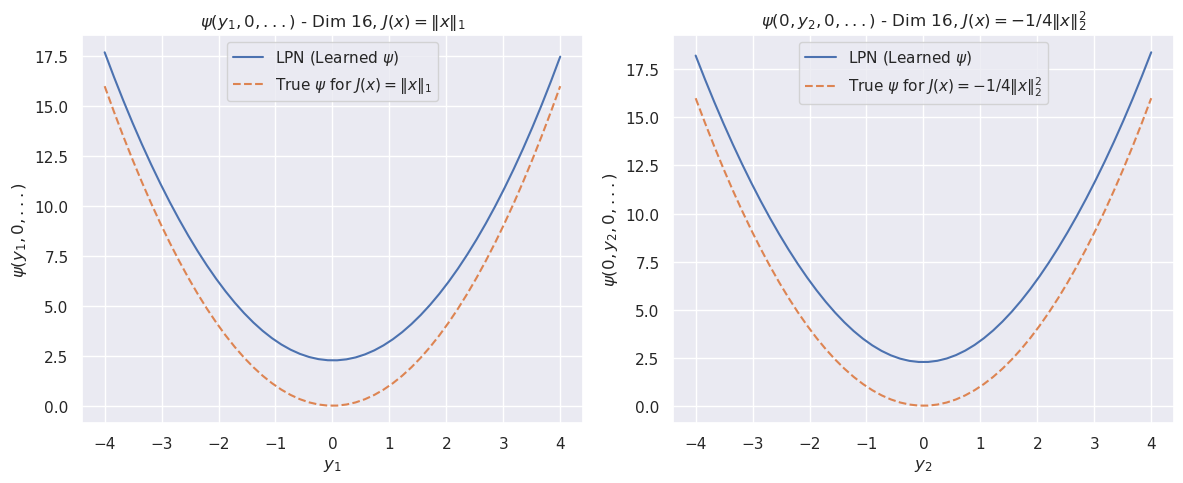

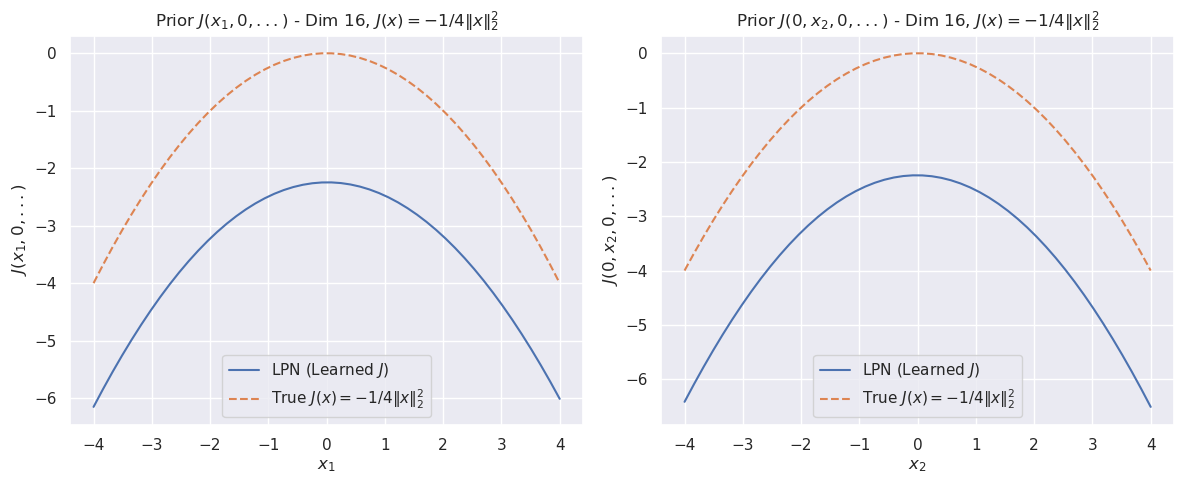

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")




Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7389.548828125
iteration 0 loss 256.4874572753906


iteration 500 loss 72.18230438232422


iteration 1000 loss 69.0487060546875


iteration 1500 loss 65.40492248535156


iteration 2000 loss 60.805233001708984


iteration 2500 loss 54.27315139770508


iteration 3000 loss 41.648216247558594


iteration 3500 loss 17.091672897338867


iteration 4000 loss 5.059755325317383


iteration 4500 loss 2.836202621459961


iteration 5000 loss 2.0973012447357178


iteration 5500 loss 1.628583312034607


iteration 6000 loss 1.3851131200790405


iteration 6500 loss 1.2742031812667847


iteration 7000 loss 1.1621471643447876


iteration 7500 loss 1.0480568408966064


iteration 8000 loss 0.9344821572303772


iteration 8500 loss 0.8242790699005127


iteration 9000 loss 0.7210573554039001


iteration 9500 loss 0.6603109836578369


iteration 10000 loss 0.6321162581443787


iteration 10500 loss 0.6012802124023438


iteration 11000 loss 0.5667662620544434


iteration 11500 loss 0.5286054611206055


iteration 12000 loss 0.487996369600296


iteration 12500 loss 0.45532548427581787


iteration 13000 loss 0.4438520669937134


iteration 13500 loss 0.43329498171806335


iteration 14000 loss 0.4210551679134369


iteration 14500 loss 0.40655842423439026


iteration 15000 loss 0.3894956111907959


iteration 15500 loss 0.36974284052848816


iteration 16000 loss 0.3683103621006012


iteration 16500 loss 0.3448416292667389


iteration 17000 loss 0.33824747800827026


iteration 17500 loss 0.3306053876876831


iteration 18000 loss 0.32144367694854736


iteration 18500 loss 0.3104989230632782


iteration 19000 loss 0.2975955009460449


iteration 19500 loss 0.2874428331851959


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.28205549716949463


iteration 20500 loss 0.2815503478050232


iteration 21000 loss 0.2809140682220459


iteration 21500 loss 0.28011971712112427


iteration 22000 loss 0.27912506461143494


iteration 22500 loss 0.27787885069847107


iteration 23000 loss 0.2763161361217499


iteration 23500 loss 0.27435797452926636


iteration 24000 loss 0.27190783619880676


iteration 24500 loss 0.2688543200492859


iteration 25000 loss 0.26507359743118286


iteration 25500 loss 0.26043272018432617


iteration 26000 loss 0.2547931671142578


iteration 26500 loss 0.24803848564624786


iteration 27000 loss 0.24008892476558685


iteration 27500 loss 0.23096461594104767


iteration 28000 loss 0.22817362844944


iteration 28500 loss 0.22606195509433746


iteration 29000 loss 0.22343946993350983


iteration 29500 loss 0.22020485997200012


iteration 30000 loss 0.21625547111034393


iteration 30500 loss 0.21148376166820526


iteration 31000 loss 0.20579616725444794


iteration 31500 loss 0.20998883247375488


iteration 32000 loss 0.19822733104228973


iteration 32500 loss 0.1966729462146759


iteration 33000 loss 0.19473598897457123


iteration 33500 loss 0.19233576953411102


iteration 34000 loss 0.18938525021076202


iteration 34500 loss 0.18579722940921783


iteration 35000 loss 0.1814878135919571


iteration 35500 loss 0.17691032588481903


iteration 36000 loss 0.1758442372083664


iteration 36500 loss 0.17468245327472687


iteration 37000 loss 0.17322617769241333


iteration 37500 loss 0.1714082956314087


iteration 38000 loss 0.16915631294250488


iteration 38500 loss 0.16638563573360443


iteration 39000 loss 0.16301874816417694


iteration 39500 loss 0.21539902687072754


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.15841145813465118


iteration 40500 loss 0.15832272171974182


iteration 41000 loss 0.15821093320846558


iteration 41500 loss 0.15807101130485535


iteration 42000 loss 0.15789294242858887


iteration 42500 loss 0.15766479074954987


iteration 43000 loss 0.15737828612327576


iteration 43500 loss 0.15701645612716675


iteration 44000 loss 0.15656332671642303


iteration 44500 loss 0.15599921345710754


iteration 45000 loss 0.15530280768871307


iteration 45500 loss 0.1544523686170578


iteration 46000 loss 0.15342815220355988


iteration 46500 loss 0.15221452713012695


iteration 47000 loss 0.1507994532585144


iteration 47500 loss 0.14918261766433716


iteration 48000 loss 0.1473725289106369


iteration 48500 loss 0.1453864872455597


iteration 49000 loss 0.14351023733615875


iteration 49500 loss 0.14172925055027008


iteration 50000 loss 0.13993148505687714


iteration 50500 loss 0.13831354677677155


iteration 51000 loss 0.13661059737205505


iteration 51500 loss 0.13508081436157227


iteration 52000 loss 0.13350920379161835


iteration 52500 loss 0.1321335881948471


iteration 53000 loss 0.13060042262077332


iteration 53500 loss 0.12935799360275269


iteration 54000 loss 0.12804152071475983


iteration 54500 loss 0.12659673392772675


iteration 55000 loss 0.12539727985858917


iteration 55500 loss 0.12404955923557281


iteration 56000 loss 0.12286616116762161


iteration 56500 loss 0.12165819108486176


iteration 57000 loss 0.12040288001298904


iteration 57500 loss 0.11934515833854675


iteration 58000 loss 0.11814957857131958


iteration 58500 loss 0.11708077788352966


iteration 59000 loss 0.11607471853494644


iteration 59500 loss 0.11493556946516037


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.11390192061662674


iteration 60500 loss 0.11379687488079071


iteration 61000 loss 0.11367698758840561


iteration 61500 loss 0.11354125291109085


iteration 62000 loss 0.11338868737220764


iteration 62500 loss 0.11322241276502609


iteration 63000 loss 0.11304475367069244


iteration 63500 loss 0.11285770684480667


iteration 64000 loss 0.11266341060400009


iteration 64500 loss 0.11246372014284134


iteration 65000 loss 0.1122603788971901


iteration 65500 loss 0.11205461621284485


iteration 66000 loss 0.11184743791818619


iteration 66500 loss 0.11163968592882156


iteration 67000 loss 0.11143193393945694


iteration 67500 loss 0.11122465133666992


iteration 68000 loss 0.11101796478033066


iteration 68500 loss 0.11081238090991974


iteration 69000 loss 0.11060820519924164


iteration 69500 loss 0.11040540039539337


iteration 70000 loss 0.11020377278327942


iteration 70500 loss 0.11000321805477142


iteration 71000 loss 0.10980374366044998


iteration 71500 loss 0.10960524529218674


iteration 72000 loss 0.10940787941217422


iteration 72500 loss 0.10921160876750946


iteration 73000 loss 0.10901622474193573


iteration 73500 loss 0.1088217943906784


iteration 74000 loss 0.10862825810909271


iteration 74500 loss 0.10843551903963089


iteration 75000 loss 0.10824371874332428


iteration 75500 loss 0.10805276781320572


iteration 76000 loss 0.10786256939172745


iteration 76500 loss 0.10767330974340439


iteration 77000 loss 0.10748473554849625


iteration 77500 loss 0.10729685425758362


iteration 78000 loss 0.10710979998111725


iteration 78500 loss 0.10692346841096878


iteration 79000 loss 0.10673803091049194


iteration 79500 loss 0.1065533459186554


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.10636934638023376


iteration 80500 loss 0.10635188221931458


iteration 81000 loss 0.10633433610200882


iteration 81500 loss 0.10631675273180008


iteration 82000 loss 0.10629912465810776


iteration 82500 loss 0.10628152638673782


iteration 83000 loss 0.10626396536827087


iteration 83500 loss 0.10624634474515915


iteration 84000 loss 0.10622873902320862


iteration 84500 loss 0.10621115565299988


iteration 85000 loss 0.10619357228279114


iteration 85500 loss 0.10617604106664658


iteration 86000 loss 0.10615848004817963


iteration 86500 loss 0.10614095628261566


iteration 87000 loss 0.1061234176158905


iteration 87500 loss 0.10610590875148773


iteration 88000 loss 0.10608839988708496


iteration 88500 loss 0.10607089847326279


iteration 89000 loss 0.1060534343123436


iteration 89500 loss 0.10603595525026321


iteration 90000 loss 0.10601849108934402


iteration 90500 loss 0.10600102692842484


iteration 91000 loss 0.10598359256982803


iteration 91500 loss 0.10596616566181183


iteration 92000 loss 0.10594876110553741


iteration 92500 loss 0.1059313639998436


iteration 93000 loss 0.10591395944356918


iteration 93500 loss 0.10589658468961716


iteration 94000 loss 0.10587918758392334


iteration 94500 loss 0.10586182028055191


iteration 95000 loss 0.10584448277950287


iteration 95500 loss 0.10582706332206726


iteration 96000 loss 0.10580974817276001


iteration 96500 loss 0.10579238086938858


iteration 97000 loss 0.10577506572008133


iteration 97500 loss 0.10575775057077408


iteration 98000 loss 0.10574048012495041


iteration 98500 loss 0.10572317987680435


iteration 99000 loss 0.10570590943098068


iteration 99500 loss 0.10568862408399582


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


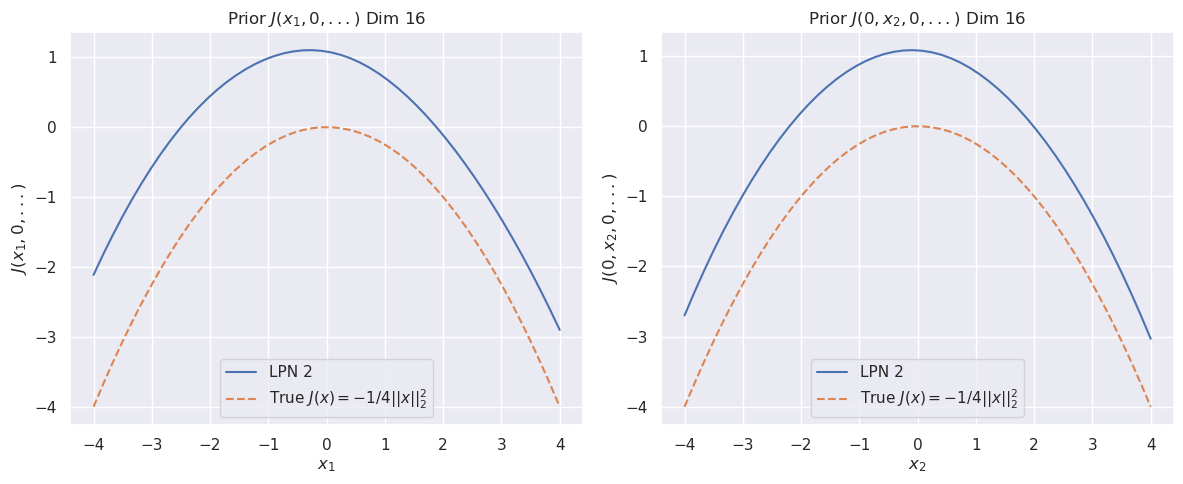

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)